# Retail Location Intelligence Demo with Azure Maps

---
Azure Maps (http://bit.ly/2VV39SG) can be used by Retailers to better understand a location. Isochrones around the store location enable retailers to perform searches within the Isochrone to determine the demographic mix, parking spaces, parking spaces, competitors and other businesses that could potentially help drive traffic to for from the business.


---

In [53]:
import os
import json
import time
import requests
import urllib.parse
from IPython.display import Image, display

Load Subscription Key for Azure Maps from Config File. If you dont have an Azure Maps Subscription Key, get yourself a free account here: http://bit.ly/2VV39SG

In [48]:
config_file = 'config.json'
key = json.load(open(config_file))['key']
subscriptionKey = key

Westlake Center, considered Seattle's "town square", is a four-storey shopping center in Downtown Seattle. Surrounding the mall, Seattle's main shopping district draws scores of both locals and visitors. We are looking at a 10min (600sec) drive-time zone around Westlake Center for our analysis. 

In [49]:
currentLocation = [47.6125983,-122.3379045]
driveTime = 600


Create an Isochrone around the Westlake Center using the Route Range API (http://bit.ly/2NGXcs3). This service will calculate a set of locations that can be reached from the origin point based on fuel, energy, or time budget that is specified. A polygon boundary (or Isochrone) is returned in a counterclockwise orientation as well as the precise polygon center which was the result of the origin point.

In [54]:
routeRangeResponse = requests.get("https://atlas.microsoft.com/route/range/json?subscription-key={}&api-version=1.0&query=47.6125983,-122.3379045&timeBudgetInSec=600".format(subscriptionKey)).json()

Below is the returned polygon that can be used for further processing such as Search Inside Geometry to search for POIs within the provided Isochrone.

In [32]:
routeRangeResponse

{'formatVersion': '0.0.1',
 'reachableRange': {'center': {'latitude': 47.61249, 'longitude': -122.3378},
  'boundary': [{'latitude': 47.69055, 'longitude': -122.34419},
   {'latitude': 47.67705, 'longitude': -122.34605},
   {'latitude': 47.66222, 'longitude': -122.35576},
   {'latitude': 47.65414, 'longitude': -122.35907},
   {'latitude': 47.6547, 'longitude': -122.36063},
   {'latitude': 47.64116, 'longitude': -122.35828},
   {'latitude': 47.63959, 'longitude': -122.36369},
   {'latitude': 47.64436, 'longitude': -122.37625},
   {'latitude': 47.64107, 'longitude': -122.37622},
   {'latitude': 47.63348, 'longitude': -122.38423},
   {'latitude': 47.63301, 'longitude': -122.38921},
   {'latitude': 47.62042, 'longitude': -122.36072},
   {'latitude': 47.617, 'longitude': -122.35629},
   {'latitude': 47.61187, 'longitude': -122.3495},
   {'latitude': 47.61096, 'longitude': -122.34795},
   {'latitude': 47.61006, 'longitude': -122.34645},
   {'latitude': 47.60921, 'longitude': -122.34499},
   

Extract the polygon bounding points from the RouteRangeResponse

In [55]:
polyBounds = routeRangeResponse["reachableRange"]["boundary"]


for i in range(len(polyBounds)):
    coordList = list(polyBounds[i].values())
    coordList[0], coordList[1] = coordList[1], coordList[0]
    polyBounds[i] = coordList

polyBounds.pop()
polyBounds.append(polyBounds[0])

boundsData = {
               "geometry": {
                 "type": "Polygon",
                 "coordinates": 
                   [
                      polyBounds
                   ]
                }
             }


The extracted polygon data looks like this:

In [56]:
boundsData

{'geometry': {'type': 'Polygon',
  'coordinates': [[[-122.34562, 47.69056],
    [-122.34605, 47.67705],
    [-122.35655, 47.66256],
    [-122.35787, 47.66344],
    [-122.36235, 47.65648],
    [-122.36093, 47.6418],
    [-122.36357, 47.64152],
    [-122.37629, 47.64724],
    [-122.37622, 47.64107],
    [-122.38423, 47.63348],
    [-122.39229, 47.63232],
    [-122.36072, 47.62042],
    [-122.35629, 47.617],
    [-122.3495, 47.61187],
    [-122.34795, 47.61096],
    [-122.34645, 47.61006],
    [-122.34499, 47.60921],
    [-122.34434, 47.60878],
    [-122.37478, 47.57556],
    [-122.37714, 47.56455],
    [-122.36331, 47.56795],
    [-122.36291, 47.56135],
    [-122.35302, 47.56511],
    [-122.34818, 47.57093],
    [-122.33946, 47.56422],
    [-122.33511, 47.54015],
    [-122.32066, 47.5387],
    [-122.3199, 47.54093],
    [-122.30195, 47.54104],
    [-122.28648, 47.514],
    [-122.29709, 47.56158],
    [-122.29518, 47.56097],
    [-122.28902, 47.56708],
    [-122.28762, 47.57804],
    [-12

Search for Starbucks in the Polygon around Westlake Center. You can edit this parameter to look for parking or any other entity.

In [57]:
searchPolyResponse = requests.post(url = "https://atlas.microsoft.com/search/geometry/json?subscription-key={}&api-version=1.0&query=starbucks&idxSet=POI&limit=50".format(subscriptionKey), json = boundsData).json()

Populate the Starbucks locations into searchLocations

In [59]:
searchLocations = []
for loc in range(len(searchPolyResponse["results"])):
                location = list(searchPolyResponse["results"][loc]["position"].values())
                location[0], location[1] = location[1], location[0]
                searchLocations.append(location)

Upload the polygon data using the Azure Data Upload Service (http://bit.ly/2LDD9dJ) 

In [60]:
rangeData = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          polyBounds
        ]
      }
    }
  ]
}

# Upload range data to Azure Maps data service.
uploadRangeResponse = requests.post(url = "https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = rangeData)


rangeUdidRequest = uploadRangeResponse.headers["Location"]+"&subscription-key=tTk1JVEaeNvDkxxnxHm9cYaCvqlOq1u-fXTvyXn2XkA"

while True:
    getRangeUdid = requests.get(rangeUdidRequest).json()
    if 'udid' in getRangeUdid:
        break
    else:
        time.sleep(0.2)
rangeUdid = getRangeUdid["udid"]

Upload the POI Data

In [61]:
poiData = {
    "type": "FeatureCollection",
    "features": [
      {
        "type": "Feature",
        "properties": {},
        "geometry": {
            "type": "MultiPoint",
            "coordinates": searchLocations
        }
    }
  ]
}

uploadPOIsResponse = requests.post(url = "https://atlas.microsoft.com/mapData/upload?subscription-key={}&api-version=1.0&dataFormat=geojson".format(subscriptionKey), json = poiData)

poiUdidRequest = uploadPOIsResponse.headers["Location"]+"&subscription-key=tTk1JVEaeNvDkxxnxHm9cYaCvqlOq1u-fXTvyXn2XkA"

while True:
    getPoiUdid = requests.get(poiUdidRequest).json()
    if 'udid' in getPoiUdid:
        break
    else:
        time.sleep(0.2)
poiUdid = getPoiUdid["udid"]

Display the map using the Render Map Image API. The static image service renders a user-defined, rectangular image containing a map section using a zoom level from 0 to 20 http://bit.ly/2lGQ3N2

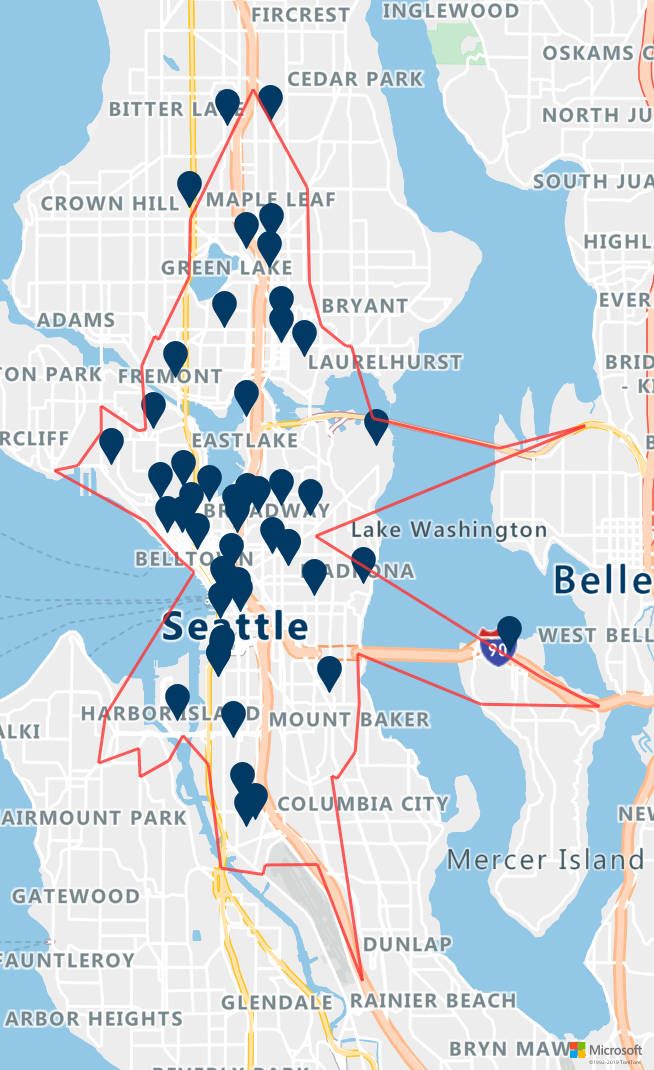

In [72]:
# Get bounds for bounding box.
def getBounds(polyBounds):
    maxLon = max(map(lambda x: x[0], polyBounds))
    minLon = min(map(lambda x: x[0], polyBounds))

    maxLat = max(map(lambda x: x[1], polyBounds))
    minLat = min(map(lambda x: x[1], polyBounds))
    
    lonBuffer = (maxLon-minLon)
    minLon -= lonBuffer
    maxLon += lonBuffer

    latBuffer = (maxLat-minLat)
    minLat -= latBuffer
    maxLat += latBuffer
    
    return [minLon, maxLon, minLat, maxLat]

minLon, maxLon, minLat, maxLat = getBounds(polyBounds)

path = "lcff3333|lw3|la0.80|fa0.35||udid-{}".format(rangeUdid)
#pins = "custom|an15 53||udid-{}||https://cdn4.iconfinder.com/data/icons/Starbucks_coffee/PNG/512x512/starbucks_coffee_1.png".format(poiUdid)
pins = "default|an15 53||udid-{}".format(poiUdid)

encodedPins = urllib.parse.quote(pins, safe='')


staticMapResponse = requests.get("https://atlas.microsoft.com/map/static/png?api-version=1.0&subscription-key={}&pins={}&path={}&bbox={}&zoom=11".format(subscriptionKey,encodedPins,path,str(minLon)+", "+str(minLat)+", "+str(maxLon)+", "+str(maxLat)))


#poiRangeMap = await staticMapResponse.content.read()
poiRangeMap = staticMapResponse.content

display(Image(poiRangeMap))
